# Main

In [1]:
# this is the main of the project
%matplotlib inline 
# libraries
import pandas as pd
import geopandas
import os
import matplotlib
import sklearn
import numpy as np
import mglearn
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import statistics as st
from sklearn import preprocessing
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans 
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from scipy.cluster.hierarchy import linkage, dendrogram
# custom libraries
from Geographycal_functions import drop_non_geolocalised
from Geographycal_functions import localize_tweets
from Geographycal_functions import localize_USA
from Preprocessing_functions import parallelize_dataframe
from Preprocessing_functions import text_preprocessing
from Preprocessing_functions import text_mining
from Preprocessing_functions import safe_drop_attr
from Preprocessing_functions import select_dates_tweets
from Geographycal_functions import assign_color, plot_clustering_results

# visualize progresses
from tqdm.auto import tqdm

if os.path.isdir(".\Processed_data")==False:
    os.mkdir(".\Processed_data")
%matplotlib inline 

# Import data

In [2]:
if os.path.isfile(".\Processed_data\States_mineddf_total.csv"):                       # we can choose one of the two
    state_df = pd.read_csv(".\Processed_data\States_mined.csv")
    # finish here
    undone_flag = False
else:
    # import the raw data
    data_donald = pd.read_csv("hashtag_donaldtrump.csv", lineterminator='\n')
    data_joe = pd.read_csv("hashtag_joebiden.csv", lineterminator='\n')
    
    # joining the two datasets dropping duplicates!!
    data_all = pd.concat([data_joe,data_donald]).drop_duplicates().reset_index(drop=True)
    
    # flag to be used in the next steps of the project
    undone_flag = True 

# Preprocessing - Geolocalization

In [3]:
if undone_flag:
    print("Geolocalization")
    data_all = drop_non_geolocalised(data_all, "lat", "long")
    geo_df = localize_tweets(data_all, "World Tweet data distribution")
    df = localize_USA(geo_df, "USA Tweets data distribution")

Geolocalization
The number of instances in the df is:  1747804
The number of instances after dropping the non localized records is:  801011


C:\Users\Toumba\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
d:\Learning_data\DDS\Main\DDS_project-main\try_full\Geographycal_functions.py:71: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: None

  gdf = geopandas.sjoin(usa, gdf, how="inner", op='contains')


The number of tweets available is: 388853 



# Preprocessing - text mining
We considered only the data localized in the USA.

This diminished the number of instances by a lot.

In [4]:
if undone_flag:
    # data to drop
    to_be_deleted = ["tweet_id", "source", "user_id", "user_join_date", "user_location", "continent", "collected_at"]
    # drop
    df = safe_drop_attr(df, to_be_deleted)

In [5]:
undone_flag=True
if undone_flag:
    
    if os.path.isfile("./Processed_data\Df_languages_detected.csv"): ## Check if languages file exists 
        df=pd.read_csv("./Processed_data\Df_languages_detected.csv")
    else:
        # Text mining
        df = text_preprocessing(df)
        # save those preliminary results, since run_time is high
        df.to_csv(".\Processed_data\Df_languages_detected.csv")
    
    df, lang_state_df = text_mining(df)
    df.to_csv(".\Processed_data\Df_mined.csv")

100%|██████████| 388853/388853 [2:08:32<00:00, 50.42it/s]


In [6]:
if undone_flag:
    # save the data into a folder
    df.to_csv(".\Processed_data\Df_mined.csv")
    lang_state_df.to_csv(".\Processed_data\lang_share_df.csv")

In [7]:
if undone_flag:
    # get the lenght of the dataframe to normalize the data
    num_instances = len(df["STATE_NAME"])

# Select different time-frames from our data

In particular we select the dates before the last public debate, before the elections and after the election day

In [8]:
undone_flag = True
df = pd.read_csv(".\Processed_data\Df_mined.csv")

#lang_state_df = pd.read_csv(".\Processed_data\States_mined.csv", usecols=["STATE_NAME", "%_english"])
print(df.shape)

# get the temporal division!
df_last_debate, df_election_day, df_total = select_dates_tweets(df)
print("Number of tweets till the day of the last debate: ", len(df_last_debate))
print("Number of tweets till the day of the elections: ", len(df_election_day))
print("Number of total tweets: ", len(df_total))

(388853, 19)
Number of tweets till the day of the last debate:  88636
Number of tweets till the day of the elections:  263306
Number of total tweets:  388853


In [9]:
my_dfs = [df_last_debate, df_election_day, df_total]
supp_names = ["df_last_debate", "df_election_day", "df_total"]

# Create the ML dataframe

Since we are squeezing all our data into 51 elements, we want to add to each state as much information about the statistical population they represents, we are therefore adding some statistics to the dataframe.
Each statistic is related to

In [11]:
if undone_flag:
    for df in my_dfs:
        df.drop(columns=["DRAWSEQ", "index_right", "Unnamed: 0", 
                         "STATE_FIPS", "SUB_REGION", "STATE_ABBR", "geometry", "created_at",
                        "user_screen_name", "user_description", "Languages", "user_name"],inplace=True)

In [12]:
if undone_flag:
    # creating dictionaries
    state_df = {}
    supp = 0
    
    for df in my_dfs:
        # visualize the bar 
        tqdm.pandas(desc="Statistical mining: ")
        num_instances = len(df)
    
        # initialize an empty list where to append the statistics
        state_list = []
        # group the data by state
        df_groupby = df.groupby(["STATE_NAME"])
        # averages
        state_list.append(df_groupby.mean(numeric_only=True).add_suffix("_Mean"))
        # skewness
        state_list.append(df_groupby.skew(numeric_only=True).add_suffix("_Skewness"))  
        # median
        state_list.append(df_groupby.median(numeric_only=True).add_suffix("_Median"))  
        # count the tweets and normalize the count wrt the total number of instances
        # state_list.append(df_groupby.count().add_suffix("_Counts") / num_instances)  
        # variance
        state_list.append(df_groupby.var().add_suffix("_Variance"))
        # standard deviation
        state_list.append(df_groupby.std().add_suffix("_Std"))
        # 0.1 quantile
        state_list.append(df_groupby.quantile(q=0.1).add_suffix("_0_1_quant"))
        # 0.9 quantile
        state_list.append(df_groupby.quantile(q=0.9).add_suffix("_0_9_quant"))
        
        
        # concatenate all those data to create a large dataframe
        state_df[supp_names[supp]] = pd.concat(state_list, axis=1)
        
        # % of english speakers
        # state_df[supp_names[supp]].merge(lang_state_df, on="STATE_NAME")
        
        # create a key for the non categorical values
        logic = [col != "STATE_NAME" for col in state_df[supp_names[supp]].columns]
        original_key = state_df[supp_names[supp]].columns 
        key = state_df[supp_names[supp]].columns[logic]
        
        ## scale
        #state_df[supp_names[supp] + "_scaled"] = my_scaler.fit_transform(
        #    state_df[supp_names[supp]].loc[:, key])
        #
        ## trasform in a df
        #state_df[supp_names[supp] + "_scaled"] = pd.DataFrame(
        #    state_df[supp_names[supp] + "_scaled"], columns=key)
        #
        ## add the state name
        #state_df[supp_names[supp] + "_scaled"] = pd.concat(
        #    [pd.Series(df_groupby.groups.keys()), state_df[supp_names[supp] + "_scaled"]], axis=1)
        
        # save
        state_df[supp_names[supp]].to_csv(".\Processed_data\States_mined" + supp_names[supp] + ".csv")
        
        # update index
        supp += 1

<ipython-input-12-7b08bf35ce3b>:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  state_list.append(df_groupby.quantile(q=0.1).add_suffix("_0_1_quant"))
<ipython-input-12-7b08bf35ce3b>:30: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  state_list.append(df_groupby.quantile(q=0.9).add_suffix("_0_9_quant"))
<ipython-input-12-7b08bf35ce3b>:28: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  state_list.append(df_groupby.quantile(q=0.1).add_suffix("_0_1_quant"))
<ipython-input-1

In [13]:
state_df["df_election_day"].head(5)

,likes_Mean,retweet_count_Mean,user_followers_count_Mean,TextBlob_Subjectivity_Mean,TextBlob_Polarity_Mean,likes_Skewness,retweet_count_Skewness,user_followers_count_Skewness,TextBlob_Subjectivity_Skewness,TextBlob_Polarity_Skewness,...,likes_0_1_quant,retweet_count_0_1_quant,user_followers_count_0_1_quant,TextBlob_Subjectivity_0_1_quant,TextBlob_Polarity_0_1_quant,likes_0_9_quant,retweet_count_0_9_quant,user_followers_count_0_9_quant,TextBlob_Subjectivity_0_9_quant,TextBlob_Polarity_0_9_quant
STATE_NAME,,,,,,,,,,,,,,,,,,,,,
Alabama,3.875874,1.095280,8374.406469,0.339647,0.079804,14.649100,13.358431,3.177572,0.446737,0.430516,...,0.0,0.0,23.0,0.0,-0.157500,6.0,2.0,8958.0,0.80,0.500000
Alaska,0.898662,0.271511,2464.818356,0.341844,0.051959,9.460180,21.212594,5.306806,0.332601,0.554995,...,0.0,0.0,11.0,0.0,-0.199062,2.0,0.8,4055.0,0.75,0.400000
Arizona,2.654507,0.738056,2924.439398,0.319254,0.061104,15.211403,13.855179,12.340654,0.509926,0.096939,...,0.0,0.0,32.0,0.0,-0.207593,3.0,1.0,7481.0,0.75,0.413333
Arkansas,1.207643,0.449682,6192.387261,0.324843,0.060139,8.892309,7.217228,4.383891,0.428717,0.567680,...,0.0,0.0,41.8,0.0,-0.185227,2.0,1.0,2673.4,0.70,0.341250
California,4.302740,1.139293,6724.195873,0.320105,0.051099,106.402440,115.622329,33.325834,0.505455,0.206356,...,0.0,0.0,25.0,0.0,-0.225000,3.0,1.0,6004.0,0.75,0.400000


## Data preprocessing for the clustering analysis - Up to last debate

In [14]:
# Read dataset for the dates leading up to the last debate
imp_dates=['Last Debate', 'Election Day', 'Whole Dataset']
counter=0 ### index to choose from dictionary imp_dates
states_scaled = pd.read_csv('.\Processed_data\States_mined%s.csv'%supp_names[counter])
print('Dimension of array:{}'.format(states_scaled.shape))


Dimension of array:(51, 36)


In [15]:
# Create correlation matrix
corr_matrix = states_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
states_scaled.drop(to_drop, axis=1, inplace=True)

In [16]:
# Firstly we should drop the columns which are not important for clustering 
# Names of states do not influence the results of clustering
state_names = states_scaled['STATE_NAME']
states_scaled.drop(['STATE_NAME'], axis=1, inplace=True)

## Some features are highly correlated, so we can exclude one of them from the analysis.
## Both features have almost the same correlation with other features, so it doesn't metter which one to exclude (it should not influence the results of clustering somehow). As 'retweet_count' has worse distribution than 'likes', it was decided to exclude 'retweet_count'.

In [17]:
# rounding to 3 decimal
states_scaled = states_scaled.round(3)

In [18]:
# PCA (principal component analysis)

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
states_scaled_pca = pca.fit_transform(states_scaled)
states_scaled_pca = np.matrix(states_scaled_pca)
print(states_scaled_pca.shape)
states_scaled_pca = pd.DataFrame(states_scaled_pca)

(51, 10)


In [19]:
# Calculate Euclidean distance (distance between dataset)
# This will ensure that the elements are combined into clusters and store them in a special variable

data_dist = pdist (states_scaled, 'euclidean')
data_linkage = linkage (data_dist, method = 'average')

## Determining the number of clusters

## Elbow Method 

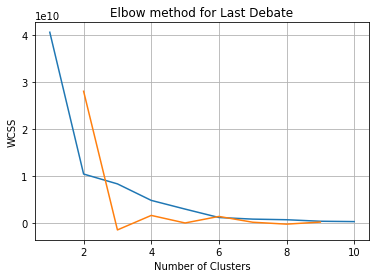

clusters for Last Debate:  2


In [20]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.title('Elbow method for %s'%(imp_dates[counter]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.grid()
plt.show()

k = acceleration_rev.argmax()+ 2 
print("clusters for %s: "%(imp_dates[counter]), k)

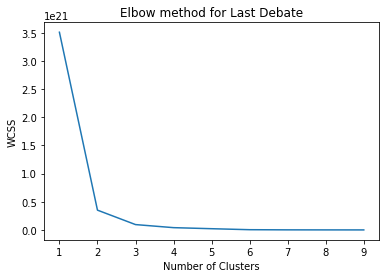

In [21]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(states_scaled) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method for %s'%(imp_dates[counter]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## According to Elbow method we should stick to 2 or 3 clusters

### Silhouette coefficient

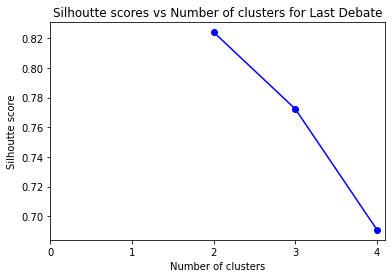

In [22]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(states_scaled, model.labels_) for model in kmeans_models[5:8]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([0,1,2,3,4])
plt.title('Silhoutte scores vs Number of clusters for %s'%imp_dates[counter])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [23]:
# determine the number of clusters using the K-means method
for n_cluster in range (2, 11):
    kmeans = KMeans (n_clusters = n_cluster) .fit (states_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score (states_scaled, label, metric = 'euclidean')
    print("Running for: %s"%imp_dates[counter])
    print ("For n_clusters = {}, The Silhouette Coefficient is {}". format (n_cluster, sil_coeff))

Running for: Last Debate
For n_clusters = 2, The Silhouette Coefficient is 0.9446810379794608
Running for: Last Debate
For n_clusters = 3, The Silhouette Coefficient is 0.8998072162636365
Running for: Last Debate
For n_clusters = 4, The Silhouette Coefficient is 0.8733710210434619
Running for: Last Debate
For n_clusters = 5, The Silhouette Coefficient is 0.8148995482255378
Running for: Last Debate
For n_clusters = 6, The Silhouette Coefficient is 0.8240546077055274
Running for: Last Debate
For n_clusters = 7, The Silhouette Coefficient is 0.7722622785661795
Running for: Last Debate
For n_clusters = 8, The Silhouette Coefficient is 0.6908440449630672
Running for: Last Debate
For n_clusters = 9, The Silhouette Coefficient is 0.6703714740681687
Running for: Last Debate
For n_clusters = 10, The Silhouette Coefficient is 0.6110033970907484


## According to the Silhouette coefficient we should stick to 2 clusters.

### Hierarchical clustering and dendrogram

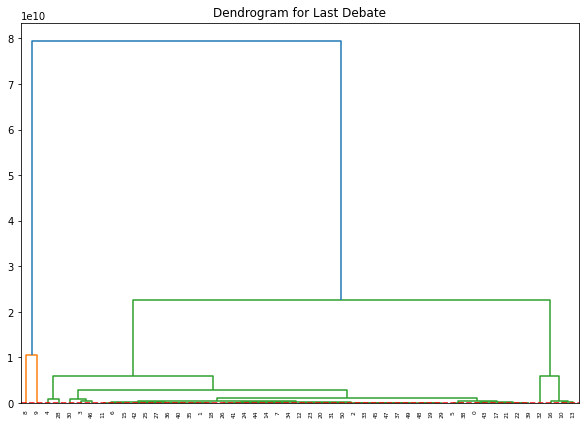

In [24]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram for %s"%imp_dates[counter])  
dend = shc.dendrogram(shc.linkage(states_scaled, method='ward'))
plt.axhline(y=2, color='r', linestyle='--')

### From hierarchical clustering we see that we should devide data into 2 or 4 clusters.

## Clustering 

### Clustering with K-means

In [25]:
# build clustering using the KMeans method
km = KMeans(n_clusters = 3, random_state = 12).fit(states_scaled)

In [26]:
# display the resulting distribution by clusters
# also the number of the cluster to which the string belongs
clustersKmean = km.labels_ + 1
print("Clusters for %s"%imp_dates[counter])
clustersKmean

Clusters for Last Debate


array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [27]:
len(km.labels_)
states_scaled['id_clusters'] = np.array(km.labels_ +1) 
states_scaled.columns

Index(['likes_Mean', 'user_followers_count_Mean', 'TextBlob_Subjectivity_Mean',
       'TextBlob_Polarity_Mean', 'likes_Skewness',
       'user_followers_count_Skewness', 'TextBlob_Subjectivity_Skewness',
       'TextBlob_Polarity_Skewness', 'likes_Median', 'retweet_count_Median',
       'user_followers_count_Median', 'TextBlob_Polarity_Median',
       'likes_Variance', 'user_followers_count_Variance',
       'TextBlob_Subjectivity_Variance', 'TextBlob_Polarity_Variance',
       'likes_0_1_quant', 'retweet_count_0_1_quant',
       'user_followers_count_0_1_quant', 'TextBlob_Subjectivity_0_1_quant',
       'TextBlob_Polarity_0_1_quant', 'likes_0_9_quant',
       'user_followers_count_0_9_quant', 'TextBlob_Subjectivity_0_9_quant',
       'TextBlob_Polarity_0_9_quant', 'id_clusters'],
      dtype='object')

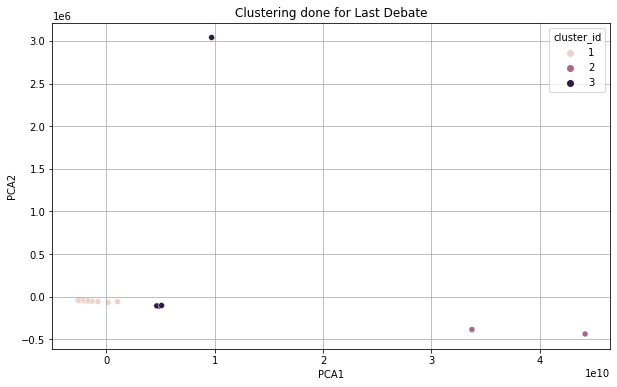

In [28]:
#Lets visualize the clusters
states_scaled['cluster_id'] = km.labels_ + 1 
states_scaled_pca = pd.DataFrame(states_scaled_pca)
states_scaled_pca['cluster_id'] = km.labels_ + 1 
states_scaled_pca = states_scaled_pca.rename(columns={0: 'PCA1', 1: 'PCA2'})
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled_pca, x='PCA1', y='PCA2', hue='cluster_id')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustering done for %s'%imp_dates[counter])
plt.grid()
plt.show()

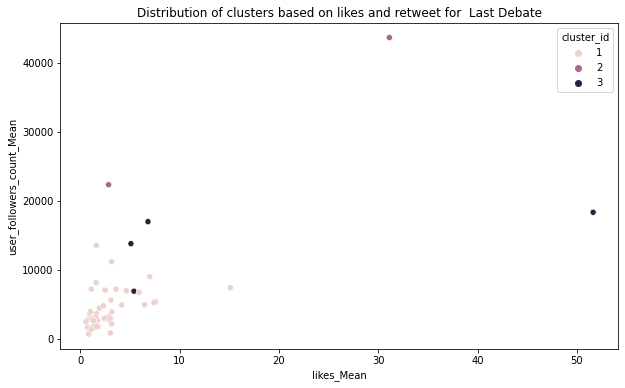

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled, x='likes_Mean', y='user_followers_count_Mean', hue='cluster_id')
plt.title('Distribution of clusters based on likes and retweet for  %s'%imp_dates[counter])
plt.show()

In [30]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

# Creating a new file with clusters
writer = pd.ExcelWriter ('states_scaled_for_clust.xlsx')
dataK.to_excel (writer, 'KMeans')
writer.save ()

# For credit PCA
data = states_scaled
data['group_no'] = clustersKmean
writer = pd.ExcelWriter ('states_scaled_for_clust_pca.xlsx')
data.to_excel (writer, 'KMeans')
writer.save ()

In [31]:
states_scaled_for_clust = pd.read_excel('states_scaled_for_clust.xlsx')
credit_dfstates_scaled = print('Dimension of array:{}'.format(states_scaled_for_clust.shape))
states_scaled_for_clust


Dimension of array:(51, 29)


,Unnamed: 0,likes_Mean,user_followers_count_Mean,TextBlob_Subjectivity_Mean,TextBlob_Polarity_Mean,likes_Skewness,user_followers_count_Skewness,TextBlob_Subjectivity_Skewness,TextBlob_Polarity_Skewness,likes_Median,...,user_followers_count_0_1_quant,TextBlob_Subjectivity_0_1_quant,TextBlob_Polarity_0_1_quant,likes_0_9_quant,user_followers_count_0_9_quant,TextBlob_Subjectivity_0_9_quant,TextBlob_Polarity_0_9_quant,id_clusters,cluster_id,group_no
0,0,4.636,6952.141,0.375,0.089,8.747,3.712,0.297,0.418,0,...,28.1,0,-0.166,7.0,5955.4,0.803,0.500,1,1,1
1,1,0.948,3657.058,0.373,0.058,5.644,3.932,-0.106,0.345,0,...,11.0,0,-0.107,2.0,7474.0,0.680,0.300,1,1,1
2,2,2.683,3156.389,0.317,0.051,13.598,8.426,0.514,-0.094,0,...,32.3,0,-0.200,4.0,7484.0,0.730,0.403,1,1,1
3,3,1.602,13539.868,0.351,0.062,7.414,2.540,0.036,0.575,0,...,50.6,0,-0.300,3.2,116842.0,0.650,0.350,1,1,1
4,4,4.182,4899.203,0.335,0.051,103.736,49.128,0.429,0.164,0,...,30.0,0,-0.233,3.0,6056.0,0.750,0.400,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,3.082,5586.635,0.351,0.042,24.728,19.641,0.409,-0.217,0,...,45.0,0,-0.250,3.0,15116.0,0.800,0.379,1,1,1
47,47,1.358,2616.787,0.349,0.028,20.366,8.439,0.403,0.003,0,...,54.7,0,-0.300,3.0,7661.2,0.802,0.400,1,1,1
48,48,1.805,1773.799,0.325,0.104,3.933,6.663,0.445,0.549,0,...,27.3,0,-0.100,4.0,7536.0,0.759,0.418,1,1,1
49,49,3.154,2164.751,0.322,0.067,17.602,9.647,0.489,0.183,0,...,21.0,0,-0.237,2.0,5351.8,0.763,0.500,1,1,1


In [32]:
print(pd.concat([states_scaled['cluster_id'],state_names], axis=1))

    cluster_id            STATE_NAME
0            1               Alabama
1            1                Alaska
2            1               Arizona
3            1              Arkansas
4            1            California
5            1              Colorado
6            1           Connecticut
7            1              Delaware
8            2  District of Columbia
9            2               Florida
10           3               Georgia
11           1                Hawaii
12           1                 Idaho
13           3              Illinois
14           1               Indiana
15           1                  Iowa
16           3                Kansas
17           1              Kentucky
18           1             Louisiana
19           1                 Maine
20           1              Maryland
21           1         Massachusetts
22           1              Michigan
23           1             Minnesota
24           1           Mississippi
25           1              Missouri
2

In [33]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

In [34]:
# Creating a new file with clusters
writer = pd.ExcelWriter('Processed_data/tweets_scaled_clust_%s.xlsx'%(imp_dates[counter]))
dataK.to_excel(writer, 'KMeans')
writer.save()

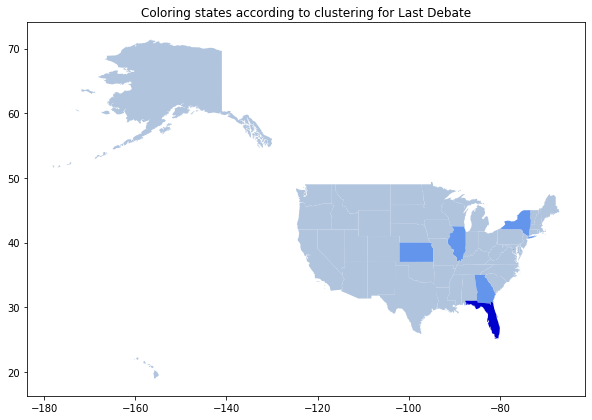

In [35]:
# upload the USA map

states_scaled = pd.concat([states_scaled, state_names], axis=1)
usa = geopandas.read_file("Maps/states.shp")
gdf = usa.merge(states_scaled, how="inner", on = 'STATE_NAME')
gdf['Color'] = gdf['cluster_id'].apply(assign_color)
plot_clustering_results(gdf)
plt.title('Coloring states according to clustering for %s'%imp_dates[counter]);

## Data preprocessing for the clustering analysis - Up to Election day

In [36]:
# Read dataset for the dates leading up to Election day
imp_dates=['Last Debate', 'Election Day', 'Whole Dataset']
counter=1 ### index to choose from dictionary imp_dates
states_scaled = pd.read_csv('.\Processed_data\States_mined%s.csv'%supp_names[counter])
print('Dimension of array:{}'.format(states_scaled.shape))


Dimension of array:(51, 36)


In [37]:
# Create correlation matrix
corr_matrix = states_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
states_scaled.drop(to_drop, axis=1, inplace=True)

In [38]:
# Firstly we should drop the columns which are not important for clustering 
# Names of states do not influence the results of clustering
state_names = states_scaled['STATE_NAME']
states_scaled.drop(['STATE_NAME'], axis=1, inplace=True)

## Some features are highly correlated, so we can exclude one of them from the analysis.
## Both features have almost the same correlation with other features, so it doesn't metter which one to exclude (it should not influence the results of clustering somehow). As 'retweet_count' has worse distribution than 'likes', it was decided to exclude 'retweet_count'.

In [39]:
# rounding to 3 decimal
states_scaled = states_scaled.round(3)

In [40]:
# PCA (principal component analysis)

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
states_scaled_pca = pca.fit_transform(states_scaled)
states_scaled_pca = np.matrix(states_scaled_pca)
print(states_scaled_pca.shape)
states_scaled_pca = pd.DataFrame(states_scaled_pca)

(51, 10)


In [41]:
# Calculate Euclidean distance (distance between dataset)
# This will ensure that the elements are combined into clusters and store them in a special variable

data_dist = pdist (states_scaled, 'euclidean')
data_linkage = linkage (data_dist, method = 'average')

## Determining the number of clusters

## Elbow Method 

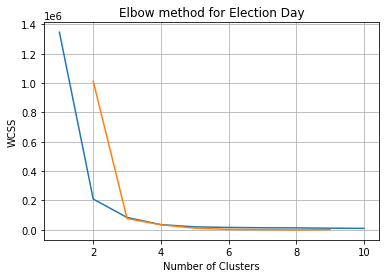

clusters for Election Day:  2


In [42]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.title('Elbow method for %s'%(imp_dates[counter]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.grid()
plt.show()

k = acceleration_rev.argmax()+ 2 
print("clusters for %s: "%(imp_dates[counter]), k)

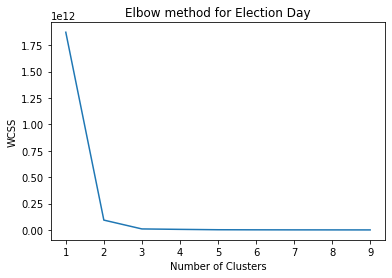

In [43]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(states_scaled) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method for %s'%(imp_dates[counter]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## According to Elbow method we should stick to 2 or 3 clusters

### Silhouette coefficient

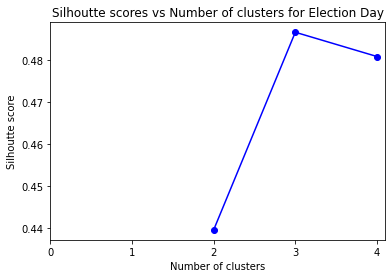

In [44]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(states_scaled, model.labels_) for model in kmeans_models[5:8]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([0,1,2,3,4])
plt.title('Silhoutte scores vs Number of clusters for %s'%imp_dates[counter])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [45]:
# determine the number of clusters using the K-means method
for n_cluster in range (2, 11):
    kmeans = KMeans (n_clusters = n_cluster) .fit (states_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score (states_scaled, label, metric = 'euclidean')
    print("Running for: %s"%imp_dates[counter])
    print ("For n_clusters = {}, The Silhouette Coefficient is {}". format (n_cluster, sil_coeff))

Running for: Election Day
For n_clusters = 2, The Silhouette Coefficient is 0.9593460414414949
Running for: Election Day
For n_clusters = 3, The Silhouette Coefficient is 0.9099261617104218
Running for: Election Day
For n_clusters = 4, The Silhouette Coefficient is 0.7028344135567701
Running for: Election Day
For n_clusters = 5, The Silhouette Coefficient is 0.6799789469846357
Running for: Election Day
For n_clusters = 6, The Silhouette Coefficient is 0.43950284398291223
Running for: Election Day
For n_clusters = 7, The Silhouette Coefficient is 0.48659557745061177
Running for: Election Day
For n_clusters = 8, The Silhouette Coefficient is 0.48081498243020243
Running for: Election Day
For n_clusters = 9, The Silhouette Coefficient is 0.47173594465771435
Running for: Election Day
For n_clusters = 10, The Silhouette Coefficient is 0.4694325668329902


## According to the Silhouette coefficient we should stick to 2 clusters.

### Hierarchical clustering and dendrogram

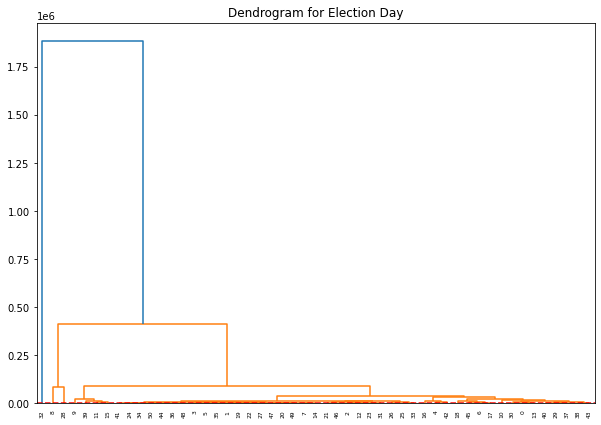

In [46]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram for %s"%imp_dates[counter])  
dend = shc.dendrogram(shc.linkage(states_scaled, method='ward'))
plt.axhline(y=2, color='r', linestyle='--')

### From hierarchical clustering we see that we should devide data into 2 or 4 clusters.

## Clustering 

### Clustering with K-means

In [47]:
# build clustering using the KMeans method
km = KMeans(n_clusters = 3, random_state = 12).fit(states_scaled)

In [48]:
# display the resulting distribution by clusters
# also the number of the cluster to which the string belongs
clustersKmean = km.labels_ + 1
print("Clusters for %s"%imp_dates[counter])
clustersKmean

Clusters for Election Day


array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [49]:
len(km.labels_)
states_scaled['id_clusters'] = np.array(km.labels_ +1) 
states_scaled.columns

Index(['likes_Mean', 'user_followers_count_Mean', 'TextBlob_Subjectivity_Mean',
       'TextBlob_Polarity_Mean', 'likes_Skewness',
       'user_followers_count_Skewness', 'TextBlob_Polarity_Skewness',
       'likes_Median', 'retweet_count_Median', 'user_followers_count_Median',
       'TextBlob_Polarity_Median', 'likes_Variance',
       'TextBlob_Subjectivity_Variance', 'TextBlob_Polarity_Variance',
       'likes_0_1_quant', 'retweet_count_0_1_quant',
       'user_followers_count_0_1_quant', 'TextBlob_Subjectivity_0_1_quant',
       'TextBlob_Polarity_0_1_quant', 'likes_0_9_quant',
       'user_followers_count_0_9_quant', 'TextBlob_Subjectivity_0_9_quant',
       'TextBlob_Polarity_0_9_quant', 'id_clusters'],
      dtype='object')

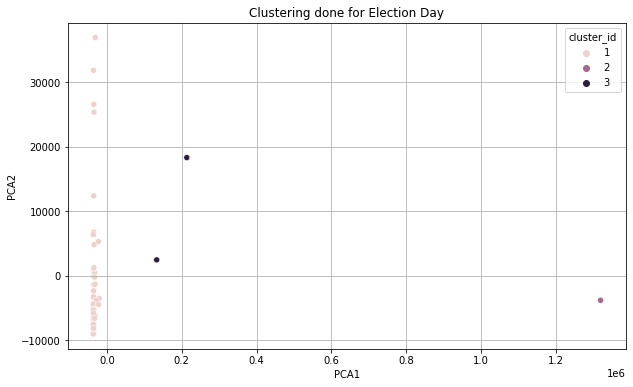

In [50]:
#Lets visualize the clusters
states_scaled['cluster_id'] = km.labels_ + 1 
states_scaled_pca = pd.DataFrame(states_scaled_pca)
states_scaled_pca['cluster_id'] = km.labels_ + 1 
states_scaled_pca = states_scaled_pca.rename(columns={0: 'PCA1', 1: 'PCA2'})
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled_pca, x='PCA1', y='PCA2', hue='cluster_id')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustering done for %s'%imp_dates[counter])
plt.grid()
plt.show()

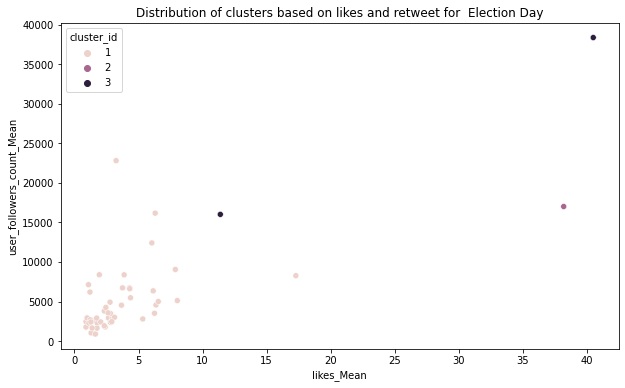

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled, x='likes_Mean', y='user_followers_count_Mean', hue='cluster_id')
plt.title('Distribution of clusters based on likes and retweet for  %s'%imp_dates[counter])
plt.show()

In [52]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

# Creating a new file with clusters
writer = pd.ExcelWriter ('states_scaled_for_clust.xlsx')
dataK.to_excel (writer, 'KMeans')
writer.save ()

# For credit PCA
data = states_scaled
data['group_no'] = clustersKmean
writer = pd.ExcelWriter ('states_scaled_for_clust_pca.xlsx')
data.to_excel (writer, 'KMeans')
writer.save ()

In [53]:
states_scaled_for_clust = pd.read_excel('states_scaled_for_clust.xlsx')
credit_dfstates_scaled = print('Dimension of array:{}'.format(states_scaled_for_clust.shape))
states_scaled_for_clust


Dimension of array:(51, 27)


,Unnamed: 0,likes_Mean,user_followers_count_Mean,TextBlob_Subjectivity_Mean,TextBlob_Polarity_Mean,likes_Skewness,user_followers_count_Skewness,TextBlob_Polarity_Skewness,likes_Median,retweet_count_Median,...,user_followers_count_0_1_quant,TextBlob_Subjectivity_0_1_quant,TextBlob_Polarity_0_1_quant,likes_0_9_quant,user_followers_count_0_9_quant,TextBlob_Subjectivity_0_9_quant,TextBlob_Polarity_0_9_quant,id_clusters,cluster_id,group_no
0,0,3.876,8374.406,0.340,0.080,14.649,3.178,0.431,0,0,...,23.0,0,-0.157,6.0,8958.0,0.80,0.500,1,1,1
1,1,0.899,2464.818,0.342,0.052,9.460,5.307,0.555,0,0,...,11.0,0,-0.199,2.0,4055.0,0.75,0.400,1,1,1
2,2,2.655,2924.439,0.319,0.061,15.211,12.341,0.097,0,0,...,32.0,0,-0.208,3.0,7481.0,0.75,0.413,1,1,1
3,3,1.208,6192.387,0.325,0.060,8.892,4.384,0.568,0,0,...,41.8,0,-0.185,2.0,2673.4,0.70,0.341,1,1,1
4,4,4.303,6724.196,0.320,0.051,106.402,33.326,0.206,0,0,...,25.0,0,-0.225,3.0,6004.0,0.75,0.400,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,2.775,4917.135,0.328,0.051,27.763,22.544,0.017,0,0,...,45.0,0,-0.229,3.0,7751.0,0.75,0.400,1,1,1
47,47,1.280,2410.284,0.348,0.070,20.039,14.199,0.272,0,0,...,47.0,0,-0.236,3.0,5471.0,0.75,0.491,1,1,1
48,48,1.380,1654.883,0.335,0.065,5.875,6.791,0.377,0,0,...,42.0,0,-0.200,3.0,3403.0,0.80,0.469,1,1,1
49,49,2.324,1936.769,0.322,0.071,21.211,9.149,0.242,0,0,...,20.0,0,-0.215,3.0,5145.0,0.75,0.500,1,1,1


In [54]:
print(pd.concat([states_scaled['cluster_id'],state_names], axis=1))

    cluster_id            STATE_NAME
0            1               Alabama
1            1                Alaska
2            1               Arizona
3            1              Arkansas
4            1            California
5            1              Colorado
6            1           Connecticut
7            1              Delaware
8            3  District of Columbia
9            1               Florida
10           1               Georgia
11           1                Hawaii
12           1                 Idaho
13           1              Illinois
14           1               Indiana
15           1                  Iowa
16           1                Kansas
17           1              Kentucky
18           1             Louisiana
19           1                 Maine
20           1              Maryland
21           1         Massachusetts
22           1              Michigan
23           1             Minnesota
24           1           Mississippi
25           1              Missouri
2

In [55]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

In [56]:
# Creating a new file with clusters
writer = pd.ExcelWriter('Processed_data/tweets_scaled_clust_%s.xlsx'%(imp_dates[counter]))
dataK.to_excel(writer, 'KMeans')
writer.save()

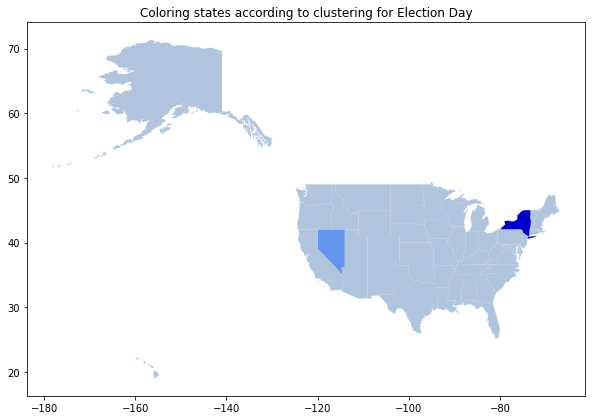

In [57]:
# upload the USA map

states_scaled = pd.concat([states_scaled, state_names], axis=1)
usa = geopandas.read_file("Maps/states.shp")
gdf = usa.merge(states_scaled, how="inner", on = 'STATE_NAME')
gdf['Color'] = gdf['cluster_id'].apply(assign_color)
plot_clustering_results(gdf)
plt.title('Coloring states according to clustering for %s'%imp_dates[counter]);

## Data preprocessing for the clustering analysis - Whole dataset

In [58]:
# Read dataset for the dates for the whole dataset
imp_dates=['Last Debate', 'Election Day', 'Whole Dataset']
counter=2 ### index to choose from dictionary imp_dates
states_scaled = pd.read_csv('.\Processed_data\States_mined%s.csv'%supp_names[counter])
print('Dimension of array:{}'.format(states_scaled.shape))


Dimension of array:(51, 36)


In [59]:
# Create correlation matrix
corr_matrix = states_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
states_scaled.drop(to_drop, axis=1, inplace=True)

In [60]:
# Firstly we should drop the columns which are not important for clustering 
# Names of states do not influence the results of clustering
state_names = states_scaled['STATE_NAME']
states_scaled.drop(['STATE_NAME'], axis=1, inplace=True)

## Some features are highly correlated, so we can exclude one of them from the analysis.
## Both features have almost the same correlation with other features, so it doesn't metter which one to exclude (it should not influence the results of clustering somehow). As 'retweet_count' has worse distribution than 'likes', it was decided to exclude 'retweet_count'.

In [61]:
# rounding to 3 decimal
states_scaled = states_scaled.round(3)

In [62]:
# PCA (principal component analysis)

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
states_scaled_pca = pca.fit_transform(states_scaled)
states_scaled_pca = np.matrix(states_scaled_pca)
print(states_scaled_pca.shape)
states_scaled_pca = pd.DataFrame(states_scaled_pca)

(51, 10)


In [63]:
# Calculate Euclidean distance (distance between dataset)
# This will ensure that the elements are combined into clusters and store them in a special variable

data_dist = pdist (states_scaled, 'euclidean')
data_linkage = linkage (data_dist, method = 'average')

## Determining the number of clusters

## Elbow Method 

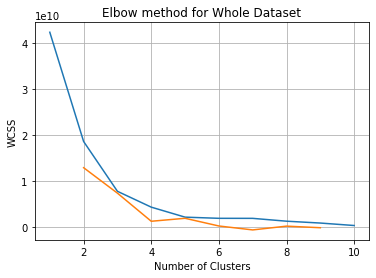

clusters for Whole Dataset:  2


In [64]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.title('Elbow method for %s'%(imp_dates[counter]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.grid()
plt.show()

k = acceleration_rev.argmax()+ 2 
print("clusters for %s: "%(imp_dates[counter]), k)

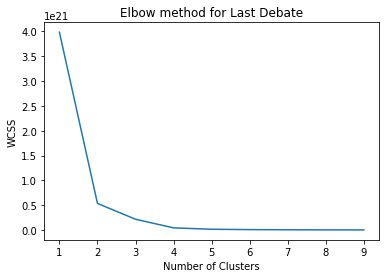

In [65]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(states_scaled) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method for %s'%(imp_dates[0]))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## According to Elbow method we should stick to 2 or 3 clusters

### Silhouette coefficient

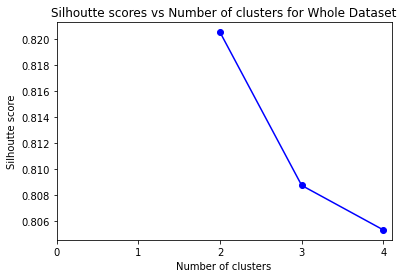

In [66]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(states_scaled, model.labels_) for model in kmeans_models[5:8]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([0,1,2,3,4])
plt.title('Silhoutte scores vs Number of clusters for %s'%imp_dates[counter])
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [67]:
# determine the number of clusters using the K-means method
for n_cluster in range (2, 11):
    kmeans = KMeans (n_clusters = n_cluster) .fit (states_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score (states_scaled, label, metric = 'euclidean')
    print("Running for: %s"%imp_dates[counter])
    print ("For n_clusters = {}, The Silhouette Coefficient is {}". format (n_cluster, sil_coeff))

Running for: Whole Dataset
For n_clusters = 2, The Silhouette Coefficient is 0.9328288722922022
Running for: Whole Dataset
For n_clusters = 3, The Silhouette Coefficient is 0.8847883589916072
Running for: Whole Dataset
For n_clusters = 4, The Silhouette Coefficient is 0.8676332527454961
Running for: Whole Dataset
For n_clusters = 5, The Silhouette Coefficient is 0.8598875840854682
Running for: Whole Dataset
For n_clusters = 6, The Silhouette Coefficient is 0.8205465099315172
Running for: Whole Dataset
For n_clusters = 7, The Silhouette Coefficient is 0.8087486875223778
Running for: Whole Dataset
For n_clusters = 8, The Silhouette Coefficient is 0.8053197840875123
Running for: Whole Dataset
For n_clusters = 9, The Silhouette Coefficient is 0.7934794831296275
Running for: Whole Dataset
For n_clusters = 10, The Silhouette Coefficient is 0.6035731937879658


## According to the Silhouette coefficient we should stick to 2 clusters.

### Hierarchical clustering and dendrogram

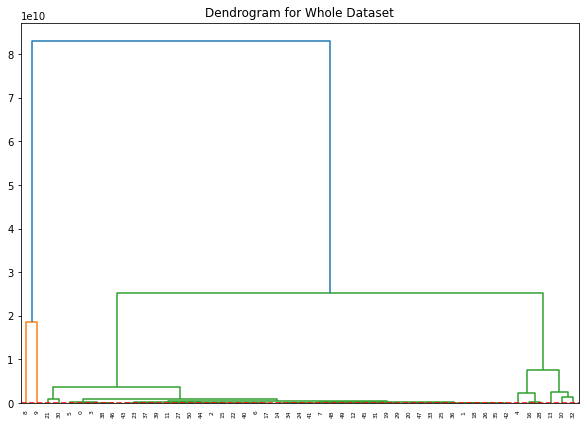

In [68]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram for %s"%imp_dates[counter])  
dend = shc.dendrogram(shc.linkage(states_scaled, method='ward'))
plt.axhline(y=2, color='r', linestyle='--')

### From hierarchical clustering we see that we should devide data into 2 or 4 clusters.

## Clustering 

### Clustering with K-means

In [69]:
# build clustering using the KMeans method
km = KMeans(n_clusters = 3, random_state = 12).fit(states_scaled)

In [70]:
# display the resulting distribution by clusters
# also the number of the cluster to which the string belongs
clustersKmean = km.labels_ + 1
print("Clusters for %s"%imp_dates[counter])
clustersKmean

Clusters for Whole Dataset


array([1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [71]:
len(km.labels_)
states_scaled['id_clusters'] = np.array(km.labels_ +1) 
states_scaled.columns

Index(['likes_Mean', 'user_followers_count_Mean', 'TextBlob_Subjectivity_Mean',
       'TextBlob_Polarity_Mean', 'likes_Skewness',
       'user_followers_count_Skewness', 'TextBlob_Subjectivity_Skewness',
       'TextBlob_Polarity_Skewness', 'likes_Median', 'retweet_count_Median',
       'user_followers_count_Median', 'TextBlob_Polarity_Median',
       'likes_Variance', 'user_followers_count_Variance',
       'TextBlob_Subjectivity_Variance', 'TextBlob_Polarity_Variance',
       'likes_0_1_quant', 'retweet_count_0_1_quant',
       'user_followers_count_0_1_quant', 'TextBlob_Subjectivity_0_1_quant',
       'TextBlob_Polarity_0_1_quant', 'likes_0_9_quant',
       'user_followers_count_0_9_quant', 'TextBlob_Polarity_0_9_quant',
       'id_clusters'],
      dtype='object')

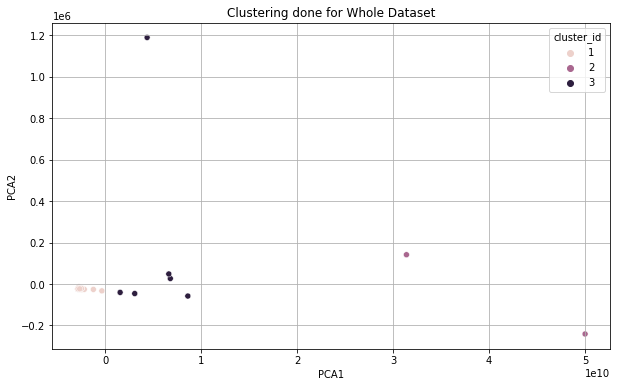

In [72]:
#Lets visualize the clusters
states_scaled['cluster_id'] = km.labels_ + 1 
states_scaled_pca = pd.DataFrame(states_scaled_pca)
states_scaled_pca['cluster_id'] = km.labels_ + 1 
states_scaled_pca = states_scaled_pca.rename(columns={0: 'PCA1', 1: 'PCA2'})
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled_pca, x='PCA1', y='PCA2', hue='cluster_id')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clustering done for %s'%imp_dates[counter])
plt.grid()
plt.show()

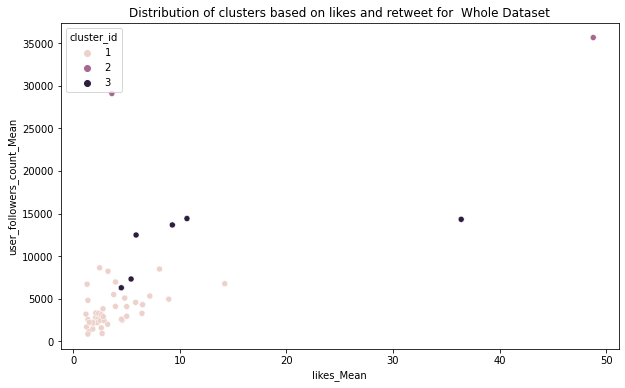

In [73]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled, x='likes_Mean', y='user_followers_count_Mean', hue='cluster_id')
plt.title('Distribution of clusters based on likes and retweet for  %s'%imp_dates[counter])
plt.show()

In [74]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

# Creating a new file with clusters
writer = pd.ExcelWriter ('states_scaled_for_clust.xlsx')
dataK.to_excel (writer, 'KMeans')
writer.save ()

# For credit PCA
data = states_scaled
data['group_no'] = clustersKmean
writer = pd.ExcelWriter ('states_scaled_for_clust_pca.xlsx')
data.to_excel (writer, 'KMeans')
writer.save ()

In [75]:
states_scaled_for_clust = pd.read_excel('states_scaled_for_clust.xlsx')
credit_dfstates_scaled = print('Dimension of array:{}'.format(states_scaled_for_clust.shape))
states_scaled_for_clust


Dimension of array:(51, 28)


,Unnamed: 0,likes_Mean,user_followers_count_Mean,TextBlob_Subjectivity_Mean,TextBlob_Polarity_Mean,likes_Skewness,user_followers_count_Skewness,TextBlob_Subjectivity_Skewness,TextBlob_Polarity_Skewness,likes_Median,...,retweet_count_0_1_quant,user_followers_count_0_1_quant,TextBlob_Subjectivity_0_1_quant,TextBlob_Polarity_0_1_quant,likes_0_9_quant,user_followers_count_0_9_quant,TextBlob_Polarity_0_9_quant,id_clusters,cluster_id,group_no
0,0,3.968,6975.042,0.336,0.084,15.354,3.666,0.461,0.339,0,...,0,19.0,0,-0.156,6.0,8226.0,0.500,1,1,1
1,1,1.192,3201.983,0.332,0.061,8.201,4.311,0.328,0.583,0,...,0,11.0,0,-0.195,3.0,4188.0,0.417,1,1,1
2,2,5.017,2947.507,0.321,0.069,38.971,22.353,0.517,0.208,0,...,0,27.0,0,-0.200,4.0,5949.0,0.433,1,1,1
3,3,1.372,4821.268,0.325,0.073,8.065,5.192,0.466,0.480,0,...,0,34.3,0,-0.194,3.0,2187.0,0.400,1,1,1
4,4,5.425,7322.299,0.319,0.066,95.096,32.793,0.514,0.298,0,...,0,25.0,0,-0.200,4.0,5792.0,0.438,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,3.958,4114.299,0.326,0.066,47.228,26.122,0.485,0.236,0,...,0,41.0,0,-0.200,4.0,5365.5,0.405,1,1,1
47,47,1.495,2258.628,0.341,0.075,16.506,17.798,0.387,0.295,0,...,0,40.0,0,-0.223,3.0,4219.4,0.500,1,1,1
48,48,2.627,1598.081,0.319,0.059,11.279,7.323,0.491,0.197,0,...,0,23.0,0,-0.219,4.0,4465.0,0.469,1,1,1
49,49,3.230,2012.863,0.330,0.078,31.142,8.384,0.452,0.323,0,...,0,16.0,0,-0.200,3.0,5137.0,0.500,1,1,1


In [76]:
print(pd.concat([states_scaled['cluster_id'],state_names], axis=1))

    cluster_id            STATE_NAME
0            1               Alabama
1            1                Alaska
2            1               Arizona
3            1              Arkansas
4            3            California
5            1              Colorado
6            1           Connecticut
7            1              Delaware
8            2  District of Columbia
9            2               Florida
10           3               Georgia
11           1                Hawaii
12           1                 Idaho
13           3              Illinois
14           1               Indiana
15           1                  Iowa
16           3                Kansas
17           1              Kentucky
18           1             Louisiana
19           1                 Maine
20           1              Maryland
21           1         Massachusetts
22           1              Michigan
23           1             Minnesota
24           1           Mississippi
25           1              Missouri
2

In [77]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

In [78]:
# Creating a new file with clusters
writer = pd.ExcelWriter('Processed_data/tweets_scaled_clust_%s.xlsx'%(imp_dates[counter]))
dataK.to_excel(writer, 'KMeans')
writer.save()

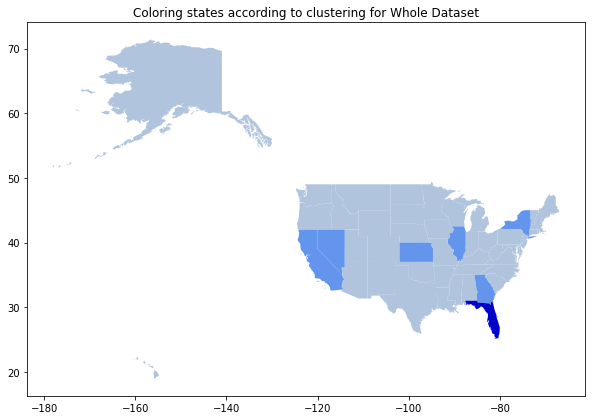

In [79]:
# upload the USA map

states_scaled = pd.concat([states_scaled, state_names], axis=1)
usa = geopandas.read_file("Maps/states.shp")
gdf = usa.merge(states_scaled, how="inner", on = 'STATE_NAME')
gdf['Color'] = gdf['cluster_id'].apply(assign_color)
plot_clustering_results(gdf)
plt.title('Coloring states according to clustering for %s'%imp_dates[counter]);